In [14]:
pip install rouge-score==0.1.2

Note: you may need to restart the kernel to use updated packages.


In [33]:
import pandas as pd
import numpy as np
import re
import requests
import csv
from bs4 import BeautifulSoup

from collections import Counter
from rouge_score import rouge_scorer

from tqdm import tqdm 
import re, difflib, unicodedata
from urllib.parse import urlparse
from typing import List, Tuple

import matplotlib.pyplot as plt

In [16]:
from utilits import * 

# Задача:

Выполнить оценку работы библиотеки по извлечению текста новости. Необходимо определить полноту извлекаемого текста и оценить значимость тех частей текста, которые выделить не удалось. Проанализировать и предложить изменения в алгоритм работы библиотеки.

---

# Желаемый результат:

Заполненная таблица:

- с эталоном текста для каждой новости;
- с результатами оценки полноты (сравнения эталона текста и текста, извлеченного библиотекой);
- оценка значимости текста, который выделить не удалось;
- комментарии, если есть предложения по улучшению.

In [17]:
df = pd.read_excel("Test_check.xlsx", sheet_name="sasha_3")
df.head(3)

,URL,lib_text
0,https://expert.ru/ekonomika/vygodna-li-rossii-...,Серьезнее других от введения западных санкций ...
1,https://ria.ru/20250311/klyuchevaya_stavka-196...,"МОСКВА, 14 фев — РИА Новости Ключевая процентн..."
2,https://expert.ru/mnenie/denis-manturov-gosuda...,Со следующего года начнется реализация 12 мега...


# Часть 1: подготовка данных

In [61]:
df = pd.read_excel("Test_check.xlsx", sheet_name="sasha_3")
df = df.rename(columns={"lib_text":"extracted_text"})
df["source"] = df["URL"].apply(get_domain)
# df = df.loc[df['source'] != 'ria.ru']            # я хз, как распарсить долбаные ria.ru...html

df[["reference_text"]] = df.apply(process_row, axis=1)
# df_raw = df.copy()                               # на всякий случай сохранимся

df.to_excel("output.xlsx", index=False)
#df.to_csv('out.csv', sep="~",  quoting=csv.QUOTE_ALL) # ломается табличный вид и-за текстового поля

[ERROR]: Проблема с извлечением текста по ссылке:  << https://ria.ru/20250311/klyuchevaya_stavka-1962773695.html >>, 

[ERROR]: Проблема с извлечением текста по ссылке:  << https://ria.ru/20250304/kredity-2003042476.html >>, 

[ERROR]: Проблема с извлечением текста по ссылке:  << https://ria.ru/docs/about/privacy_policy.html >>, 

[ERROR]: Проблема с извлечением текста по ссылке:  << https://ria.ru/docs/about/privacy_policy.html#1748006692-13 >>, 

[ERROR]: Проблема с извлечением текста по ссылке:  << https://ria.ru/20250310/es-2003634059.html >>, 

[ERROR]: Проблема с извлечением текста по ссылке:  << https://ria.ru/20250311/siriya-2004136885.html >>, 

[ERROR]: Проблема с извлечением текста по ссылке:  << https://ria.ru/20250311/gorbachev-2004161660.html >>, 

[ERROR]: Проблема с извлечением текста по ссылке:  << https://ria.ru/20250310/kallas-2003924425.html >>, 

[ERROR]: Проблема с извлечением текста по ссылке:  << https://ria.ru/20250311/vojska-2004271868.html >>, 

[ERROR]: Проб

### Часть текста неочень хорошо распарсилась или подтянулась.

=> Готовлю REF тексты вручную: 

https://docs.google.com/spreadsheets/d/1Vn1m_me98BxiLcw0z63zB5bgj6rvSdaPt_VY-Pg6TWg/edit?usp=sharing

### Какой должна быть запись в столбце с референсом?

- без заголовков, авторов, даты (если они вне основного тела);
- без "мусора": рекламы, виджетов, кнопок соцсетей, комментариев;
- текст самой статьи
- подзаголовки и важные подписи к изображениям, если они несут смысл;
- сохраняем структуру текста

In [62]:
df_manual = pd.read_excel("references.xlsx")
merged_df = pd.merge(df, df_manual, left_on=df.columns[0], right_on=df_manual.columns[0])

merged_df = merged_df.drop_duplicates(subset=['extracted_text'])
print('After remove duplicates:', merged_df.shape)

After remove duplicates: (43, 5)


In [63]:
merged_df.head(5)

,URL,extracted_text,source,reference_text,reference_text_manual
0,https://expert.ru/ekonomika/vygodna-li-rossii-...,Серьезнее других от введения западных санкций ...,expert.ru,Серьезнее других от введения западных санкций ...,=== Выгодна ли России отмена санкций США ===\n...
1,https://ria.ru/20250311/klyuchevaya_stavka-196...,"МОСКВА, 14 фев — РИА Новости Ключевая процентн...",ria.ru,,"=== Ключевая ставка ЦБ РФ: для чего нужна, поч..."
2,https://expert.ru/mnenie/denis-manturov-gosuda...,Со следующего года начнется реализация 12 мега...,expert.ru,Со следующего года начнется реализация 12 мега...,=== Денис Мантуров: «Государство в рамках нацп...
3,https://ria.ru/20250304/kredity-2003042476.html,Самозапрет на кредиты - это новая возможность ...,ria.ru,,"=== Самозапрет на кредиты: суть, как оформить,..."
4,https://lenta.ru/brief/2025/03/11/green/,"Заходя в магазин, вы часто замечали зеленые уп...",lenta.ru,"Заходя в магазин, вы часто замечали зеленые уп...",=== Компании по всему миру врут об экологичнос...


> **Note:**
> 1. Если прохoдиться по ссылкам ria.ru и открывать их руками, почти со всеми возникает проблема, просто нельзя открыть сайт. Предполагаю, проблема связана с тем, что открываю не из России.
> 2. Те ссылки на ria.ru, которые открылись: возможно, также влияет то, с какого именно браузера открывать ссылку.

Оставим строки, для которых есть поле `reference_text_manual`.

Остальные строки убираем из дальнейшего анализа.

In [64]:
merged_df=merged_df[~(merged_df['reference_text_manual'].isna())]
merged_df=merged_df[['URL', 'source', 'extracted_text', 'reference_text_manual']]
merged_df = merged_df.rename(columns={"reference_text_manual":"reference_text"})
print("Number of lines after filtration: ", merged_df.shape[0])

merged_df['reference_text_no_markers'] = clean_series(merged_df['reference_text'])
merged_df.head(3)

Number of lines after filtration:  30


,URL,source,extracted_text,reference_text,reference_text_no_markers
0,https://expert.ru/ekonomika/vygodna-li-rossii-...,expert.ru,Серьезнее других от введения западных санкций ...,=== Выгодна ли России отмена санкций США ===\n...,Выгодна ли России отмена санкций США \nОслабле...
1,https://ria.ru/20250311/klyuchevaya_stavka-196...,ria.ru,"МОСКВА, 14 фев — РИА Новости Ключевая процентн...","=== Ключевая ставка ЦБ РФ: для чего нужна, поч...","Ключевая ставка ЦБ РФ: для чего нужна, почему ..."
2,https://expert.ru/mnenie/denis-manturov-gosuda...,expert.ru,Со следующего года начнется реализация 12 мега...,=== Денис Мантуров: «Государство в рамках нацп...,Денис Мантуров: «Государство в рамках нацпроек...


# Часть 2: анализ схожести текстов в целом

Как мы можем оценить полноту текста?
1. Какая вообще доля референсного текста была извлечена?

$ Recall = \frac{\text{кол-во верно извлеченных слов}}{\text{кол-во слов в рефренсе}} => TP/REF $

2. Какая доля извлеченного текста вобще была в референсе изначально?

$ Presicion = \frac{\text{кол-во верно извлеченных слов}}{\text{кол-во извлечнных слов}} => TP/EXTR$

3.  Jaccard Similarity => Какое пересечение есть между множествами слов в референсе и извлечённом тексте?

$ Jaccard = {∣A ∪ B∣|}{∣A ∩ B∣} $, где A и B — множества слов из референсного и извлечённого текстов

Рассмотрим отедельно взятую новость:

In [65]:
reference = merged_df['reference_text'].iloc[11]
extracted = merged_df['extracted_text'].iloc[11]

ref_chunks = parse_markup(reference)
ext_chunks = parse_markup(extracted)

missing, extra = find_missing_extra(ref_chunks, ext_chunks)

print("MISSING:")
for s, lbl in missing:
    print(f"[{lbl[:8]}] {s}")

print("EXTRA:")
for sent, lbl in extra:
    print(f"[{lbl}] {sent}…")

MISSING:
[title] «Мне было страшно на это смотреть» 50 лет назад в давке в Москве погиб 21 человек.
[title] Как бесплатная жвачка привела к трагедии?
[subtitle] 50 лет назад в Сокольниках 21 человек погиб в давке после хоккейного матча
[body] 0 марта 1975 года, ровно 50 лет назад, произошла одна из самых массовых по числу жертв трагедий в истории отечественного спорта.
[vrezka] Министр здравоохранения Борис Петровский объявил жевание жвачки вредной привычной, к тому же пропагандирующей капиталистический образ жизни
[body] Эта жвачка была очень жесткой, - говорит «Ленте.ру» московский школьник конца 1960-х Андрей Тимин.
[vrezka] Турне канадских спортсменов спонсировал крупный производитель жевательной резинки.
[vrezka] Каждому хоккеисту вручили по тяжелой коробке и попросили раздавать советским людям в качестве рекламной акции
[vrezka] Были там и канадские болельщики - родители хоккеистов, кто-то из посольства, - рассказывал Кожевников «CЭ» в наше время.
[vrezka] - Смеха ради швыряли на

In [66]:
merged_df[["extr_len", "ref_len", "p", "r", "f1", "jaccard"]] = merged_df.apply(basic_metrics, axis=1)
merged_df["len_diff"] = merged_df.extr_len - merged_df.ref_len

merged_df[[
    "missing_chunks", "extra_chunks", "missing_cnt", "extra_cnt",
    "lost_title_cnt", "lost_vrezka_cnt", "lost_body_cnt"
]] = merged_df.apply(diff_row, axis=1, result_type='expand')

merged_df.head(3)

,URL,source,extracted_text,reference_text,reference_text_no_markers,extr_len,ref_len,p,r,f1,jaccard,len_diff,missing_chunks,extra_chunks,missing_cnt,extra_cnt,lost_title_cnt,lost_vrezka_cnt,lost_body_cnt
0,https://expert.ru/ekonomika/vygodna-li-rossii-...,expert.ru,Серьезнее других от введения западных санкций ...,=== Выгодна ли России отмена санкций США ===\n...,Выгодна ли России отмена санкций США \nОслабле...,15285.0,16390.0,1.000000,0.938560,0.968307,0.950669,-1105.0,"[Выгодна ли России отмена санкций США, Ослабле...",[],8,0,1,0,6
1,https://ria.ru/20250311/klyuchevaya_stavka-196...,ria.ru,"МОСКВА, 14 фев — РИА Новости Ключевая процентн...","=== Ключевая ставка ЦБ РФ: для чего нужна, поч...","Ключевая ставка ЦБ РФ: для чего нужна, почему ...",15102.0,15996.0,0.993090,0.935814,0.963602,0.975962,-894.0,"[Ключевая ставка ЦБ РФ: для чего нужна, почему...","[(МОСКВА, 14 фев - РИА Новости Ключевая процен...",25,16,7,0,17
2,https://expert.ru/mnenie/denis-manturov-gosuda...,expert.ru,Со следующего года начнется реализация 12 мега...,=== Денис Мантуров: «Государство в рамках нацп...,Денис Мантуров: «Государство в рамках нацпроек...,20292.0,16627.0,0.742555,0.906699,0.816458,0.739943,3665.0,[Денис Мантуров: «Государство в рамках нацпрое...,[(Со следующего года начнется реализация 12 ме...,44,69,1,0,43


# Часть 3: оценка смысловой части

А что если мы имеем дело с перефразированием текста, а не просто извлечением? => посмотрим ROUGE-L (оценка по **L**ongest **C**ommon **S**equnce)

ROUGE‑L будет искать LCS для наших EXTR and REF, а затем считает:

$ Precision = \frac{\text{LCS}}{\text{ EXTR }} $, (какая доля слов EXTR текста лежит в LCS)

$ Precision = \frac{\text{LCS}}{\text{ REF }} $, (какая доля слов REF покрыта LCS)

$ F‑measure $  — гармоническое среднее Precision и Recall.

Потенциальная проблема: синонимы будут считаться разными словами.

In [67]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)

def rouge_row(row):
    ref_chunks = parse_markup(row['reference_text'])
    ext_chunks = parse_markup(row['extracted_text'])

    ref_plain = " ".join(s for s, _ in ref_chunks)
    ext_plain = " ".join(s for s, _ in ext_chunks)

    score = scorer.score(ref_plain, ext_plain)['rougeL']
    return pd.Series({
        'rougeL_r': score.recall,
        'rougeL_p': score.precision,
        'rougeL_f': score.fmeasure,
    })

In [68]:
merged_df[['rougeL_r', 'rougeL_p', 'rougeL_f']] = (
    merged_df.apply(rouge_row, axis=1, result_type='expand')
)

In [69]:
print("средний ROUGE‑L:", merged_df['rougeL_f'].mean())
full = merged_df.apply(lambda row: pd.concat([rouge_row(row), diff_row(row)]), axis=1)


средний ROUGE‑L: 0.8826176181753109


# Результаты

In [70]:
merged_df_res = merged_df[['URL', 'source',
                       "p", "r", "f1", "jaccard",
                       "missing_cnt", "extra_cnt",
                       "lost_title_cnt", "lost_vrezka_cnt", "lost_body_cnt",
                       'rougeL_r', 'rougeL_p', 'rougeL_f']]


In [71]:
merged_df_res

,URL,source,p,r,f1,jaccard,missing_cnt,extra_cnt,lost_title_cnt,lost_vrezka_cnt,lost_body_cnt,rougeL_r,rougeL_p,rougeL_f
0,https://expert.ru/ekonomika/vygodna-li-rossii-...,expert.ru,1.000000,0.938560,0.968307,0.950669,8,0,1,0,6,0.988889,1.000000,0.994413
1,https://ria.ru/20250311/klyuchevaya_stavka-196...,ria.ru,0.993090,0.935814,0.963602,0.975962,25,16,7,0,17,0.888889,0.973913,0.929461
2,https://expert.ru/mnenie/denis-manturov-gosuda...,expert.ru,0.742555,0.906699,0.816458,0.739943,44,69,1,0,43,0.417910,0.636364,0.504505
3,https://ria.ru/20250304/kredity-2003042476.html,ria.ru,1.000000,0.879310,0.935780,0.945946,23,5,4,0,13,0.875000,1.000000,0.933333
4,https://lenta.ru/brief/2025/03/11/green/,lenta.ru,1.000000,0.930814,0.964167,0.958840,12,0,6,6,0,0.967213,1.000000,0.983333
5,https://lenta.ru/articles/2025/03/09/aslan/,lenta.ru,1.000000,0.830757,0.907556,0.871520,25,0,2,22,0,0.940299,1.000000,0.969231
6,https://expert.ru/finance/investorov-svyazyvay...,expert.ru,0.999313,0.932095,0.964534,0.948905,8,2,0,2,5,1.000000,1.000000,1.000000
10,https://lenta.ru/extlink/2025/03/10/na-ukraine...,lenta.ru,1.000000,0.899068,0.946852,0.911051,7,1,2,3,1,0.949153,1.000000,0.973913
12,https://expert.ru/news/rynok-onlayn-torgovli-v...,expert.ru,1.000000,0.836364,0.910891,0.921875,3,0,1,0,2,0.865672,1.000000,0.928000
13,https://www.vesti.ru/article/4393501,vesti.ru,0.966667,0.615929,0.752432,0.663366,22,4,1,0,21,0.557143,0.764706,0.644628


In [72]:
print(f"Всего статей: {len(merged_df):,}")

num_cols = ["p", "r", "f1", "jaccard",
            "missing_cnt", "extra_cnt",
            "lost_title_cnt", "lost_vrezka_cnt",
            "lost_body_cnt", "rougeL_r", "rougeL_p", "rougeL_f"]

display( merged_df_res[num_cols].describe().T )


Всего статей: 30


,count,mean,std,min,25%,50%,75%,max
p,30.0,0.988647,0.047021,0.742555,0.998474,1.000000,1.000000,1.000000
r,30.0,0.876264,0.076119,0.615929,0.839078,0.889189,0.930155,0.959437
f1,30.0,0.926657,0.052532,0.752432,0.910458,0.935545,0.963389,0.979298
jaccard,30.0,0.906947,0.078181,0.663366,0.896441,0.924258,0.953465,0.982647
missing_cnt,30.0,19.700000,23.995905,2.000000,4.000000,10.000000,22.750000,104.000000
extra_cnt,30.0,12.200000,24.617628,0.000000,0.000000,1.000000,5.750000,94.000000
lost_title_cnt,30.0,1.533333,1.547709,0.000000,1.000000,1.000000,1.750000,7.000000
lost_vrezka_cnt,30.0,3.000000,5.589399,0.000000,0.000000,0.000000,3.000000,22.000000
lost_body_cnt,30.0,14.533333,23.960792,0.000000,1.250000,3.000000,13.750000,95.000000
rougeL_r,30.0,0.826747,0.192354,0.270588,0.802381,0.888889,0.958442,1.000000


In [73]:
by_src = (merged_df_res
          .groupby("source")
          .agg(articles     =("URL", "count"),
               rougeL_avg   =("rougeL_f", "mean"),
               f1_avg       =("f1", "mean"),
               miss_avg     =("missing_cnt", "mean"),
               extra_avg    =("extra_cnt", "mean"),
              )
          .sort_values("articles", ascending=False))

display(by_src)

,articles,rougeL_avg,f1_avg,miss_avg,extra_avg
source,,,,,
expert.ru,17,0.861992,0.932694,17.058824,13.647059
lenta.ru,8,0.928521,0.938481,25.125000,12.375000
vesti.ru,3,0.844568,0.845564,17.333333,4.666667
ria.ru,2,0.931397,0.949691,24.000000,10.500000


In [74]:
corr = merged_df_res[["rougeL_f",
                  "missing_cnt", "extra_cnt",
                  "lost_title_cnt", "lost_vrezka_cnt", "lost_body_cnt"]].corr()

display(corr["rougeL_f"].sort_values(ascending=False))

rougeL_f           1.000000
lost_vrezka_cnt    0.147571
lost_title_cnt     0.141455
missing_cnt       -0.712564
extra_cnt         -0.753214
lost_body_cnt     -0.763290
Name: rougeL_f, dtype: float64

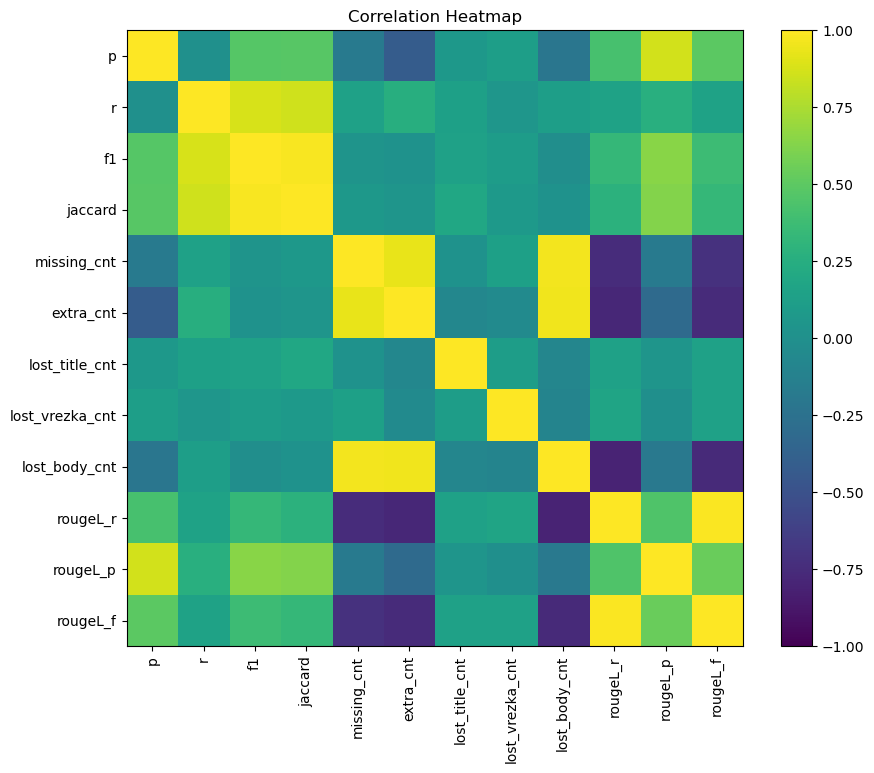

In [75]:
numeric_cols = merged_df_res.select_dtypes(include=["number"]).columns
corr = merged_df_res[numeric_cols].corr()

plt.figure(figsize=(10, 8))
im = plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")

plt.show()

# Выводы

### 1.  Как ведёт себя качество (ROUGE‑L\_f)

* Чем выше `precision (p)` и `recall (r)`, тем выше ROUGE, что логично.  
* ROUGE сильно падает, если растут  
  * `missing_cnt` – пропущенные предложения  
  * `lost_title_cnt` – пропущенные заголовки  
  * `lost_vrezka_cnt` – пропущенные «врезки»  
  * чуть слабее влияет `extra_cnt` – лишние фразы

---

### 2.  Что именно чаще теряется

* Больше всего пропусков – обычный текст (`lost_body_cnt`).  
* Но даже один пропущенный заголовок или врезка портит ROUGE почти так же, как десяток пропущенных обычных предложений. Эти блоки «весят» больше.

---

### 3.  Как связаны метрики друг с другом

| Пара метрик | Наблюдение |
|-------------|------------|
| `f1`, `jaccard`, `rougeL_f` | Почти одинаково реагируют на ошибки (корреляция ≈ 0.9). |
| `precision` ↔ `extra_cnt`  | `precision` остаётся высокой – «лишних» фраз мало. |
| `missing_cnt` ↔ `rougeL_f` | Самая сильная отрицательная связь: меньше пропусков → выше ROUGE. |

---

### 4.  Что можно сделать

1. Сократить пропуски (`missing_cnt`), особенно заголовков и врезок. Это самый быстрый способ поднять ROUGE.
2. Функция хорошо уьирает «лишнее» (высокий `precision`), поэтому сначала стоит научить ее находить больше нужных предложений, а не ужимать вывод.
3. `f1` и `jaccard` дублируют ROUGE‑L. Для отчётов можно оставить сам ROUGE‑L и счётчики пропусков/лишнего.
4. Отдельно стоит изучить сайты с большим количеством статей и низким средним ROUGE – именно они тянут итоговый результат вниз.

---

### 5.  Дальнейшие шаги

1. Проверить, почему теряются заголовки/врезки – возможно, они обособлены тегами или идут с необычной пунктуацией.  
2. Улучшить правила/модель извлечения для этих блоков.  
3. После фикса – пересчитать метрики и убедиться, что `missing_cnt` идет вниз,а ROUGE растет.

In [76]:
df = pd.read_excel("Test_check.xlsx", sheet_name="sasha_3")
df["source"] = df["URL"].apply(get_domain)

In [77]:
final_df = (
    df
    .merge(                      
        merged_df,               
        on="URL",                
        how="left",              # оставить все строки
        suffixes=("", "_calc")   # если имена колонок пересекаются
    )
)

final_df = final_df.drop(columns="source_calc")

| **Колонка**          | **Что содержит**                                                                                       |
|----------------------|--------------------------------------------------------------------------------------------------------|
| `URL`                | Ссылка на оригинальную статью.                                                                        |
| `lib_text`           | Полный очищенный текст до извлечения.                                                                  |
| `source`             | Домен / издание (пример: *ria.ru*).                                                                    |
| `extracted_text`     | Текст, который вернула ваша модель/скрипт.                                                             |
| `reference_text`     | Эталонный размеченный текст, с которым сравниваем.                                                    |
| `extr_len`           | Длина `extracted_text` (слов/токенов).                                                                 |
| `ref_len`            | Длина `reference_text`.                                                                                |
| `p`                  | Precision — доля правильных извлечений.                                                                |
| `r`                  | Recall — доля эталонных фраз, найденных в выводе.                                                      |
| `f1`                 | Гармоническое среднее `p` и `r`.                                                                       |
| `jaccard`            | Jaccard между множествами предложений эталона и вывода.                                                |
| `len_diff`           | `extr_len − ref_len` (>0 — вывод длиннее).                                                             |
| `missing_cnt`        | Сколько предложений пропущено.                                                                         |
| `extra_cnt`          | Сколько предложений лишних.                                                                            |
| `lost_title_cnt`     | Пропущенные заголовки.                                                                                 |
| `lost_vrezka_cnt`    | Пропущенные «врезки».                                                                                  |
| `lost_body_cnt`      | Пропущенные обычные абзацы.                                                                            |
| `rougeL_r`           | Recall компонента ROUGE‑L.                                                                             |
| `rougeL_p`           | Precision компонента ROUGE‑L.                                                                          |
| `rougeL_f`           | Итоговый ROUGE‑L F1.                                                                                   |


In [83]:
# Итоговый файл
final_df = final_df[['URL',
 'lib_text',
 'source',
 'extracted_text',
 'reference_text',
 'extr_len',
 'ref_len',
 'p',
 'r',
 'f1',
 'jaccard',
 'len_diff',
 'missing_cnt',
 'extra_cnt',
 'lost_title_cnt',
 'lost_vrezka_cnt',
 'lost_body_cnt',
 'rougeL_r',
 'rougeL_p',
 'rougeL_f']]

final_df.to_excel("report_.xlsx", index=False)